## This module inspects networks generated from each hyperparameter combinations, filter for the best network and assess cell type specificity

Cell Specific Analysis - 111521 Cortex G=5

In [1]:
import sys
import os

# Check the current conda environment
conda_env = os.environ.get('CONDA_DEFAULT_ENV')
print(f"Current Conda Environment: {conda_env}")

# Optionally, check the Python executable path
print(f"Python executable: {sys.executable}")

print(os.getcwd())

Current Conda Environment: oi
Python executable: /nfs/latdata/bkang/anaconda3/envs/oi/bin/python
/nfs/latdata/bkang/Codes_Publication_2024/src


In [2]:
import pickle
from gprofiler import GProfiler
import nbimporter
import numpy as np
import pandas as pd
import networkx as nx
import OmicsIntegrator as oi
import community
from scipy import stats
import warnings
#import mygene
warnings.filterwarnings('ignore')
# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
plt.rcParams['font.family'] = 'Arial'

In [3]:
# import additional modules
import OI_utils as util
import graph_cell_network_edge_update as coi

In [4]:
# write functions that are missing from util notebook
# for summarizing naive network
def generate_basic_statistics(graph,robust_results): # graph.generate_basic_statistics
    robust_summary = {}

    for paramstring, robust_network in robust_results.items(): 
        
        if robust_network.number_of_nodes() != 0: 
                
            robust_df = oi.get_networkx_graph_as_dataframe_of_nodes(robust_network)
            
            robust_edges_df = nx.to_pandas_edgelist(robust_network)
           # sum_cost = 
            robust_summary[paramstring] = {
                "W":                paramstring.split("_")[1],
                "B":                paramstring.split("_")[3],
                "G":                paramstring.split("_")[5],
                #"K":                paramstring.split("_")[7],
                "size":             len(robust_df), 
                "min_robustness":   robust_df.robustness.min(), 
                "mean_robustness":  robust_df.robustness.mean(), 
                "max_specificity":  robust_df.specificity.max(),
                "mean_specificity": robust_df.specificity.mean(), 
                "mean_log_degree":  np.log2(robust_df.degree).mean(), 
                "std_log_degree":   np.log2(robust_df.degree).std(), 
                "KS_statistic":     stats.ks_2samp(np.log2(robust_df.degree), np.log2(graph.node_attributes.degree))[0],
                "num_fly_prize": len(robust_df[robust_df.source == 'fly genetic screen']),
                "num_HD_prize" : len(robust_df[robust_df.source == "huntington's AOO modifiers"])                                     
                }
                
    robust_summary = pd.DataFrame.from_dict(robust_summary, orient='index')
    return robust_summary

# if mode = 'forest' then only subset edges that are selected by PCSF
# calculate pairwise jaccard index of networks
def pairwise_jaccard_index_from_networks(networks, mode = 'augmented_forest'):
    pairwise_df = pd.DataFrame(index = list(networks.keys()), columns = list(networks.keys()))
    for key1 in pairwise_df.index:
        for key2 in pairwise_df.index:
            network_1 = networks[key1]
            network_2 = networks[key2]
            L1 = list(network_1.edges)
            L2 = list(network_2.edges)
            if mode == 'forest':
                edge_df1 = nx.to_pandas_edgelist(network_1)
                edge_df2 = nx.to_pandas_edgelist(network_2)
                G1 = nx.from_pandas_edgelist(edge_df1[edge_df1.in_solution==True], source='source',target='target')
                G2 = nx.from_pandas_edgelist(edge_df2[edge_df2.in_solution==True], source='source',target='target')
                L1 = list(G1.edges)
                L2 = list(G2.edges)
            J = util.jaccard(L1, L2)
            pairwise_df.loc[key1, key2] = J
    pairwise_df = pairwise_df.astype('float')
    return pairwise_df

# if mode = 'forest' then only subset edges that are selected by PCSF
# calculate pairwise jaccard index of networks
def pairwise_jaccard_index_from_network_nodes(networks, mode = 'Terminal'):
    pairwise_df = pd.DataFrame(index = list(networks.keys()), columns = list(networks.keys()))
    for key1 in pairwise_df.index:
        for key2 in pairwise_df.index:
            network_1 = networks[key1]
            network_2 = networks[key2]
            node_df1 = oi.get_networkx_graph_as_dataframe_of_nodes(network_1)
            node_df2 = oi.get_networkx_graph_as_dataframe_of_nodes(network_2)
            if mode == 'Terminal':
                L1 = list(node_df1[node_df1['terminal'] == True].index)
                L2 = list(node_df2[node_df2['terminal'] == True].index)
            elif mode == 'Non-terminal':
                L1 = list(node_df1[node_df1['terminal'] == False].index)
                L2 = list(node_df2[node_df2['terminal'] == False].index)
            elif mode == 'All':
                L1 = list(node_df1.index)
                L2 = list(node_df2.index)
                            
                
            intersection = len(list(set(L1).intersection(set(L2))))
            union = (len(L1) + len(L2)) - intersection
                               
            J = float(intersection) / union
            pairwise_df.loc[key1, key2] = J
    pairwise_df = pairwise_df.astype('float')
    return pairwise_df

def get_mean_exp(adata, nodes, celltypes):
    node_genes = []
    # dealing with genes present in node AND adata
    for gene in nodes:
        if gene in adata.var_names:
            node_genes.append(gene)
    # create dataframe with only genes that are found in prize list
    means = pd.DataFrame(index = node_genes, columns = ['mean_exp', 'STD'])

    # all cells
    means['mean_exp'] = np.mean(adata[:, node_genes].X.toarray(), axis=0)                                          
    means['STD'] =  np.std(adata[:,node_genes].X.toarray(), axis = 0)
    # cell median
    for celltype in celltypes:
        means[celltype] = np.mean(adata[adata.obs['annot'] == celltype, node_genes].X.toarray(), axis=0)
    # create final output dataframe, where all of prize genes are used
    mean_df = pd.DataFrame(index= nodes, columns = ['mean_exp','STD'] + celltypes)
    
    for gene in means.index.tolist():
        mean_df.loc[gene, :] = means.loc[gene, :]
    
    mean_df.fillna(0, inplace=True)
    return mean_df

def get_cell_score(mean_df, nodes, celltypes):
    score_df = pd.DataFrame(index = nodes, columns = celltypes)
    for celltype in celltypes:
        score_df.loc[:,celltype] = (mean_df[celltype] - mean_df['mean_exp'])/mean_df['STD'] 
    score_df.fillna(0, inplace=True)
    return score_df

def get_node_scores_df(networks, expr_df, mode='Terminals'):
    rank_scores_df = pd.DataFrame(index = list(networks.keys()), columns = list(int_df.columns)[3:])
    for key1 in rank_scores_df.index:
        network = networks[key1]
    
        node_df = oi.get_networkx_graph_as_dataframe_of_nodes(network)

        # if forest mode, then only take PCSF selected edges.
        if mode == 'Terminals':
            node_df = node_df[node_df.terminal == True]
        elif mode == 'Non-terminals':
            node_df = node_df[node_df.terminal == False]
        else:
            print('proceeding with all nodes')
            
        inds = list(set(node_df.index.tolist()).intersection(set(expr_df.index.tolist())))
    
        for key2 in rank_scores_df.columns:    
            celltype = key2 # i.e. Astrocyte_rank
            gene_ranks = list(expr_df.loc[inds, celltype].values)
        
            rank_scores_df.loc[key1, key2] = sum(gene_ranks)/len(node_df)
    rank_scores_df = rank_scores_df.astype('float')
    return rank_scores_df
# wrapper function for calculating enrichment score for a given dictionary of PCSF solutions 
def get_cell_score_heatmap_df(networks, adata, mode = 'Terminals'):
    enr_scores_df = pd.DataFrame(index=list(networks.keys()), columns = list(networks.keys())[1:])
    
    for key1 in enr_scores_df.index: 
        network = networks[key1] # for each cell type network
        
        node_df = oi.get_networkx_graph_as_dataframe_of_nodes(network)
        # if forest mode, then only take PCSF selected edges.
        if mode == 'Terminals':
            node_df = node_df[node_df.terminal == True]
        elif mode == 'Non-terminals':
            node_df = node_df[node_df.terminal == False]
        else:
            print('proceeding with all nodes')
        
        mean_df = get_mean_exp(adata, node_df.index.tolist(), enr_scores_df.columns.tolist())
        scores_df = get_cell_score(mean_df, node_df.index.tolist(), enr_scores_df.columns.tolist())
        
        inds = list(set(node_df.index.tolist()).intersection(set(adata.var.index.tolist())))
        for key2 in enr_scores_df.columns:    
            celltype = key2 # i.e. Astrocyte_rank
            enr_score = list(scores_df.loc[inds, celltype].values)
            enr_scores_df.loc[key1, key2] = sum(enr_score)/len(node_df)
    enr_scores_df = enr_scores_df.astype('float')
    return enr_scores_df

## Load Naive Network and base objects

In [5]:
# Baseline Object
params = {
    "noise": 0.1, # gaussian noise to randommization
    "dummy_mode": "terminals", # connect dummy to terminals
    "exclude_terminals": False, 
    "seed": 1
}
# ngraph for naive graph
interactome_file = '../Interactome/iref17_iref14_braInMap_ptau_metab_mapped.txt'
ngraph = oi.Graph(interactome_file, params) 

# cgraph for cortex graph
params = {
    "noise": 0.1, # gaussian noise to randommization
    "dummy_mode": "terminals", # connect dummy to terminals
    "exclude_terminals": False, 
    "seed": 1,
    "cell_type" : 'Naive'}
interactome_file_cortex = '../Interactome/iref17_iref14_braInMap_ptau_metab_mapped_cortex_adjusted.txt'
cgraph = coi.Graph(interactome_file_cortex, params)

Naive Network Filtering and Summary

In [7]:
# initialize dictionary objects
robust_summary_unfiltered = {}
robust_networks_dict = {}
robust_summary_filtered = {}
mynetworks_cortex = {}
# start with Naive network
prize_file = 'prize_scaled.txt'
ngraph.prepare_prizes('../Prize_Inputs/prize_scaled.txt') # naive prize

output_dir=  '../Network_Outputs/pickles/111221_cortex/Naive_randomization_results.pkl'
print(output_dir)     
results = pickle.load(open(output_dir, 'rb'))
# prune the network - connected component of size greater than 5000 or less than 5 will be discarded.
robust_networks = { param:oi.get_robust_subgraph_from_randomizations(forests["augmented_forest"], 5000, 5) for param,forests in results.items() }

robust_summary_unfiltered_df = generate_basic_statistics(ngraph, robust_networks)
robust_summary_unfiltered['Naive'] = robust_summary_unfiltered_df    
filtered_networks = {param: util.get_filtered_subgraph_from_randomizations(forests, 0.5, 0.5) for param,forests in robust_networks.items() }
filtered_networks = {param: util.filter_graph_by_component_size(network, 5) for param, network in filtered_networks.items()}
robust_summary_df = generate_basic_statistics(ngraph, filtered_networks) # we don't have K in Naive network, so use package ver

# save to dictionary
robust_summary_unfiltered['Naive'] = robust_summary_unfiltered_df    
robust_summary_filtered['Naive'] = robust_summary_df
mynetworks_cortex['Naive'] = filtered_networks


08:48:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
08:48:51 - OI2: INFO - ['CACNA2D3', 'MAPRE1', 'CNTN6']
08:48:52 - OI2: INFO - Members of the prize file not present in the interactome:
08:48:52 - OI2: INFO - ['AC004158.3', 'AC007390.5', 'AC012146.7', 'AC126544.2', 'AC130352.1', 'AC135178.1', 'AL033532.1', 'C15orf38', 'C15orf38-AP3S2', 'C16orf14', 'C17orf108', 'C5orf45', 'CCT6P1', 'CPX5', 'CTA-445C9.14', 'CTA-445C9.15', 'CTC-228N24.3', 'Chmp1b', 'EFCAB1', 'FAM89A', 'GBX2', 'GS1-124K5.11', 'GS1-124K5.4', 'HCG27', 'HES2', 'KANSL1-AS1', 'KIBRA', 'LRRC37A', 'LRRC37A2', 'METTL21D', 'MLY2', 'NEURL1B', 'NUPR1L', 'PAQR4', 'PMS2CL', 'PSAPL1', 'RFNG', 'RP11-178A10.1', 'RP11-259G18.2', 'RP11-27I1.2', 'RP11-399D2.1', 'RP11-58B17.1', 'RP11-632K20.7', 'RP11-697E2.7', 'RP11-81A22.5', 'SAMD10', 'TLK2P1', 'ZNF738']


../Network_Outputs/pickles/111221_cortex/Naive_randomization_results.pkl


In [8]:
robust_summary_filtered['Naive']

,W,B,G,size,min_robustness,mean_robustness,max_specificity,mean_specificity,mean_log_degree,std_log_degree,KS_statistic,num_fly_prize,num_HD_prize
W_1.00_B_50.00_G_5.00,1.00,50.00,5.00,473,0.51,0.905560,0.45,0.069577,5.246582,2.024346,0.215808,148,153
W_1.00_B_100.00_G_5.00,1.00,100.00,5.00,493,0.51,0.907667,0.45,0.071623,5.230934,2.042801,0.211652,148,163


Cell Specific Network Filtering and Summary

In [9]:
########## Cortex ##########
# note that the mean edge cost is not accurate. To make this accurate, a separate graph object 
# has to be created for each of network, which will take a lot of time
# we only need to compare degree distributions, so just use the same graph object for each of cell networks
cell_types = ['Ex','In','Ast','Oli','Opc','Mic']
prize_file = 'prize_cortex_10_'
weight='10'

for cell in cell_types:
    cgraph.prepare_prizes('../Prize_Inputs/' + prize_file + cell + '.txt')
    #mycelltype = prize_file.split('_')[-1].split('.')[0]
    node_attributes_df = cgraph.node_attributes
    int_df = cgraph.interactome_dataframe
    
    output_dir=  '../Network_Outputs/pickles/111221_cortex/' + cell + '_cortex_w' + weight + '_randomization_results.pkl'
    print(output_dir)     
    
    results = pickle.load(open(output_dir, 'rb'))
    robust_networks= { param:oi.get_robust_subgraph_from_randomizations(forests["augmented_forest"], 5000, 5) for param,forests in results.items() }
    robust_summary_unfiltered_df = util.generate_basic_statistics(cgraph, robust_networks)
    robust_summary_unfiltered[cell] = robust_summary_unfiltered_df
    
    filtered_networks = {param: util.get_filtered_subgraph_from_randomizations(forests, 0.5, 0.5) for param,forests in robust_networks.items() }
    filtered_networks = {param: util.filter_graph_by_component_size(network, 5) for param, network in filtered_networks.items()}
    robust_summary_df = util.generate_basic_statistics(cgraph, filtered_networks)
    robust_summary_filtered[cell] = robust_summary_df
    mynetworks_cortex[cell] = filtered_networks

08:50:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
08:50:56 - OI2: INFO - []
08:50:56 - OI2: INFO - Members of the prize file not present in the interactome:
08:50:56 - OI2: INFO - ['AC004158.3', 'AC007390.5', 'AC012146.7', 'AC126544.2', 'AC130352.1', 'AC135178.1', 'AL033532.1', 'C15orf38', 'C15orf38-AP3S2', 'C16orf14', 'C17orf108', 'C5orf45', 'CCT6P1', 'CPX5', 'CTA-445C9.14', 'CTA-445C9.15', 'CTC-228N24.3', 'Chmp1b', 'EFCAB1', 'FAM89A', 'GBX2', 'GS1-124K5.11', 'GS1-124K5.4', 'HCG27', 'HES2', 'KANSL1-AS1', 'KIBRA', 'LRRC37A', 'LRRC37A2', 'METTL21D', 'MLY2', 'NEURL1B', 'NUPR1L', 'PAQR4', 'PMS2CL', 'PSAPL1', 'RFNG', 'RP11-178A10.1', 'RP11-259G18.2', 'RP11-27I1.2', 'RP11-399D2.1', 'RP11-58B17.1', 'RP11-632K20.7', 'RP11-697E2.7', 'RP11-81A22.5', 'SAMD10', 'TLK2P1', 'ZNF738']


../Network_Outputs/pickles/111221_cortex/Ex_cortex_w10_randomization_results.pkl


08:51:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
08:51:03 - OI2: INFO - []
08:51:03 - OI2: INFO - Members of the prize file not present in the interactome:
08:51:03 - OI2: INFO - ['AC004158.3', 'AC007390.5', 'AC012146.7', 'AC126544.2', 'AC130352.1', 'AC135178.1', 'AL033532.1', 'C15orf38', 'C15orf38-AP3S2', 'C16orf14', 'C17orf108', 'C5orf45', 'CCT6P1', 'CPX5', 'CTA-445C9.14', 'CTA-445C9.15', 'CTC-228N24.3', 'Chmp1b', 'EFCAB1', 'FAM89A', 'GBX2', 'GS1-124K5.11', 'GS1-124K5.4', 'HCG27', 'HES2', 'KANSL1-AS1', 'KIBRA', 'LRRC37A', 'LRRC37A2', 'METTL21D', 'MLY2', 'NEURL1B', 'NUPR1L', 'PAQR4', 'PMS2CL', 'PSAPL1', 'RFNG', 'RP11-178A10.1', 'RP11-259G18.2', 'RP11-27I1.2', 'RP11-399D2.1', 'RP11-58B17.1', 'RP11-632K20.7', 'RP11-697E2.7', 'RP11-81A22.5', 'SAMD10', 'TLK2P1', 'ZNF738']


../Network_Outputs/pickles/111221_cortex/In_cortex_w10_randomization_results.pkl


08:51:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
08:51:09 - OI2: INFO - []
08:51:09 - OI2: INFO - Members of the prize file not present in the interactome:
08:51:09 - OI2: INFO - ['AC004158.3', 'AC007390.5', 'AC012146.7', 'AC126544.2', 'AC130352.1', 'AC135178.1', 'AL033532.1', 'C15orf38', 'C15orf38-AP3S2', 'C16orf14', 'C17orf108', 'C5orf45', 'CCT6P1', 'CPX5', 'CTA-445C9.14', 'CTA-445C9.15', 'CTC-228N24.3', 'Chmp1b', 'EFCAB1', 'FAM89A', 'GBX2', 'GS1-124K5.11', 'GS1-124K5.4', 'HCG27', 'HES2', 'KANSL1-AS1', 'KIBRA', 'LRRC37A', 'LRRC37A2', 'METTL21D', 'MLY2', 'NEURL1B', 'NUPR1L', 'PAQR4', 'PMS2CL', 'PSAPL1', 'RFNG', 'RP11-178A10.1', 'RP11-259G18.2', 'RP11-27I1.2', 'RP11-399D2.1', 'RP11-58B17.1', 'RP11-632K20.7', 'RP11-697E2.7', 'RP11-81A22.5', 'SAMD10', 'TLK2P1', 'ZNF738']


../Network_Outputs/pickles/111221_cortex/Ast_cortex_w10_randomization_results.pkl


08:51:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
08:51:14 - OI2: INFO - []
08:51:14 - OI2: INFO - Members of the prize file not present in the interactome:
08:51:14 - OI2: INFO - ['AC004158.3', 'AC007390.5', 'AC012146.7', 'AC126544.2', 'AC130352.1', 'AC135178.1', 'AL033532.1', 'C15orf38', 'C15orf38-AP3S2', 'C16orf14', 'C17orf108', 'C5orf45', 'CCT6P1', 'CPX5', 'CTA-445C9.14', 'CTA-445C9.15', 'CTC-228N24.3', 'Chmp1b', 'EFCAB1', 'FAM89A', 'GBX2', 'GS1-124K5.11', 'GS1-124K5.4', 'HCG27', 'HES2', 'KANSL1-AS1', 'KIBRA', 'LRRC37A', 'LRRC37A2', 'METTL21D', 'MLY2', 'NEURL1B', 'NUPR1L', 'PAQR4', 'PMS2CL', 'PSAPL1', 'RFNG', 'RP11-178A10.1', 'RP11-259G18.2', 'RP11-27I1.2', 'RP11-399D2.1', 'RP11-58B17.1', 'RP11-632K20.7', 'RP11-697E2.7', 'RP11-81A22.5', 'SAMD10', 'TLK2P1', 'ZNF738']


../Network_Outputs/pickles/111221_cortex/Oli_cortex_w10_randomization_results.pkl


08:51:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
08:51:18 - OI2: INFO - []
08:51:18 - OI2: INFO - Members of the prize file not present in the interactome:
08:51:18 - OI2: INFO - ['AC004158.3', 'AC007390.5', 'AC012146.7', 'AC126544.2', 'AC130352.1', 'AC135178.1', 'AL033532.1', 'C15orf38', 'C15orf38-AP3S2', 'C16orf14', 'C17orf108', 'C5orf45', 'CCT6P1', 'CPX5', 'CTA-445C9.14', 'CTA-445C9.15', 'CTC-228N24.3', 'Chmp1b', 'EFCAB1', 'FAM89A', 'GBX2', 'GS1-124K5.11', 'GS1-124K5.4', 'HCG27', 'HES2', 'KANSL1-AS1', 'KIBRA', 'LRRC37A', 'LRRC37A2', 'METTL21D', 'MLY2', 'NEURL1B', 'NUPR1L', 'PAQR4', 'PMS2CL', 'PSAPL1', 'RFNG', 'RP11-178A10.1', 'RP11-259G18.2', 'RP11-27I1.2', 'RP11-399D2.1', 'RP11-58B17.1', 'RP11-632K20.7', 'RP11-697E2.7', 'RP11-81A22.5', 'SAMD10', 'TLK2P1', 'ZNF738']


../Network_Outputs/pickles/111221_cortex/Opc_cortex_w10_randomization_results.pkl


08:51:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
08:51:24 - OI2: INFO - []
08:51:24 - OI2: INFO - Members of the prize file not present in the interactome:
08:51:24 - OI2: INFO - ['AC004158.3', 'AC007390.5', 'AC012146.7', 'AC126544.2', 'AC130352.1', 'AC135178.1', 'AL033532.1', 'C15orf38', 'C15orf38-AP3S2', 'C16orf14', 'C17orf108', 'C5orf45', 'CCT6P1', 'CPX5', 'CTA-445C9.14', 'CTA-445C9.15', 'CTC-228N24.3', 'Chmp1b', 'EFCAB1', 'FAM89A', 'GBX2', 'GS1-124K5.11', 'GS1-124K5.4', 'HCG27', 'HES2', 'KANSL1-AS1', 'KIBRA', 'LRRC37A', 'LRRC37A2', 'METTL21D', 'MLY2', 'NEURL1B', 'NUPR1L', 'PAQR4', 'PMS2CL', 'PSAPL1', 'RFNG', 'RP11-178A10.1', 'RP11-259G18.2', 'RP11-27I1.2', 'RP11-399D2.1', 'RP11-58B17.1', 'RP11-632K20.7', 'RP11-697E2.7', 'RP11-81A22.5', 'SAMD10', 'TLK2P1', 'ZNF738']


../Network_Outputs/pickles/111221_cortex/Mic_cortex_w10_randomization_results.pkl


In [10]:
# concatenate results summary
df= robust_summary_filtered['Naive']
df['K'] = 0
df['cell_type'] = 'Naive'
#params = ['W_1.00_B_40.00_G_4_K_5', 'W_1.00_B_40.00_G_4_K_10']
final_df = df.copy()
for cell in cell_types:
    df_cell =  robust_summary_filtered[cell]
    #df_cell = df_cell.loc[params]
    df_cell['cell_type'] = cell
    final_df = final_df.append(df_cell)
cols = final_df.columns.tolist()[3:13] # subset relevant statistics
cols.insert(0, 'cell_type')
cols.insert(1, 'K')
cols.insert(2, 'size')
final_df[cols]

,cell_type,K,size,size,min_robustness,mean_robustness,max_specificity,mean_specificity,mean_log_degree,std_log_degree,KS_statistic,num_fly_prize,num_HD_prize
W_1.00_B_50.00_G_5.00,Naive,0,473,473,0.51,0.905560,0.45,0.069577,5.246582,2.024346,0.215808,148,153
W_1.00_B_100.00_G_5.00,Naive,0,493,493,0.51,0.907667,0.45,0.071623,5.230934,2.042801,0.211652,148,163
W_1.00_B_50.00_G_5_K_5,Ex,5,400,400,0.51,0.932425,0.33,0.058350,5.413070,1.938826,0.245877,142,141
W_1.00_B_50.00_G_5_K_10,Ex,10,306,306,0.51,0.948693,0.23,0.049444,5.686660,1.911188,0.297234,127,107
W_1.00_B_50.00_G_5_K_15,Ex,15,257,257,0.52,0.966459,0.13,0.046887,5.826054,1.953377,0.321140,121,95
W_1.00_B_100.00_G_5_K_5,Ex,5,420,420,0.51,0.935524,0.33,0.060500,5.414086,1.938433,0.249091,147,145
W_1.00_B_100.00_G_5_K_10,Ex,10,324,324,0.51,0.950432,0.23,0.050309,5.630230,1.934133,0.285796,132,117
W_1.00_B_100.00_G_5_K_15,Ex,15,269,269,0.52,0.970297,0.13,0.047472,5.826079,1.943518,0.319564,126,102
W_1.00_B_50.00_G_5_K_5,In,5,354,354,0.51,0.925621,0.26,0.053164,5.459943,1.952623,0.249252,131,119
W_1.00_B_50.00_G_5_K_10,In,10,262,262,0.52,0.937061,0.25,0.048626,5.740036,1.945040,0.301720,111,89


In [11]:
# save outputs
output_dir = '../Network_Outputs/pickles/111221_cortex/'
with open(output_dir + 'filtered_networks_cortex.pkl', "wb") as f: # change directory to output
    pickle.dump(mynetworks_cortex, f)
    
with open(output_dir + 'filtered_summaries_cortex.pkl', "wb") as f: # change directory to output
    pickle.dump(robust_summary_filtered, f)
    
with open(output_dir + 'unfiltered_summaries_cortex.pkl', "wb") as f: # change directory to output
    pickle.dump(robust_summary_unfiltered, f)
    
with open(output_dir + 'final_summary.pkl', 'wb') as f:
    pickle.dump(final_df, f)

with open(output_dir + 'int_df.pkl', 'wb') as f:
    pickle.dump(int_df, f)

# Generate final network with selected hyperparam

In [34]:
# laod outputs
# if loading, run this cell, otherwise, don't run this cell
output_dir = '../Network_Outputs/pickles/111221_cortex/'
mynetworks_cortex = pickle.load(open(output_dir + 'filtered_networks_cortex.pkl', 'rb'))
robust_summary_filtered = pickle.load(open(output_dir+'filtered_summaries_cortex.pkl', 'rb'))
robust_summary_unfiltered = pickle.load(open(output_dir+'unfiltered_summaries_cortex.pkl', 'rb'))
final_summary = pickle.load(open(output_dir+'final_summary.pkl', 'rb'))
int_df = pickle.load(open(output_dir+'int_df.pkl','rb'))

In [35]:
# create final network with selected hyperparams
# selecting 5, 100, 5, 2 for now for initial exploration
final_networks_5 = {} # K=5
for celltype, network in mynetworks_cortex.items():
    if celltype == 'Naive':
        final_networks_5[celltype] = network['W_1.00_B_50.00_G_5.00']
    else:        
        final_networks_5[celltype] = network['W_1.00_B_50.00_G_5_K_5']
        
final_networks_10 = {} # K=10
for celltype, network in mynetworks_cortex.items():
    if celltype == 'Naive':
        final_networks_10[celltype] = network['W_1.00_B_50.00_G_5.00']
    else:        
        final_networks_10[celltype] = network['W_1.00_B_50.00_G_5_K_10']        

## Make gene set from each subnetwork for FGSEA (all nodes, terminals, non-terminals, prize set)

In [38]:
# custom function for generating gene-set for each cell-type specific network
def make_gene_set_from_networks(networks):
    # Do the same for Terminals and non-terminals
    gene_set_networks_k_10_combined = pd.DataFrame(columns=networks.keys())

    # make a gene_set dataframe without metabolites
    network = networks['Naive']
    node_df = oi.get_networkx_graph_as_dataframe_of_nodes(network)

    # all nodes
    L_to_add = list(node_df.index)
    L_to_add = [x for x in L_to_add if not x.startswith('HMDB')]
    gene_set_final = pd.DataFrame({'Naive': L_to_add})
    
    # Terminals
    L_to_add = list(node_df[node_df['terminal'] == True].index)
    L_to_add = [x for x in L_to_add if not x.startswith('HMDB')]
    add = pd.DataFrame({'Naive_terminals': L_to_add})
    gene_set_final = pd.concat([gene_set_final, add], axis = 1)
    
    # non-terminals
    L_to_add = list(node_df[node_df['terminal'] != True].index)
    L_to_add = [x for x in L_to_add if not x.startswith('HMDB')]
    add = pd.DataFrame({'Naive_non_terminals': L_to_add})
    gene_set_final = pd.concat([gene_set_final, add], axis = 1)
    
    # do the same for all cells
    for cell in list(networks.keys())[1:]: # for each cell type network
        print(cell)
        network = networks[cell]
        node_df = oi.get_networkx_graph_as_dataframe_of_nodes(network)
        
        # all nodes
        L_to_add = list(node_df.index)
        L_to_add = [x for x in L_to_add if not x.startswith('HMDB')]
        add = pd.DataFrame({cell: L_to_add})
        print('all nodes',cell, len(L_to_add))
        gene_set_final=pd.concat([gene_set_final, add], axis=1)
        
        # Terminals
        L_to_add = list(node_df[node_df['terminal'] == True].index)
        L_to_add = [x for x in L_to_add if not x.startswith('HMDB')]
        
        add = pd.DataFrame({cell+'_terminals': L_to_add})
        print('terminals',cell, len(L_to_add))
        gene_set_final=pd.concat([gene_set_final, add], axis=1)
        
        # Non-terminals
        L_to_add = list(node_df[node_df['terminal'] == False].index)
        L_to_add = [x for x in L_to_add if not x.startswith('HMDB')]
        
        add = pd.DataFrame({cell+'_non_terminals': L_to_add})
        print('non-terminals',cell, len(L_to_add))
        gene_set_final=pd.concat([gene_set_final, add], axis=1)
    
    # formatting for FGSEA package.
    # add dummy row where it tells you about the gene_set. (just for formatting .gmt file)
    n=len(gene_set_final.columns)
    gene_set_final=pd.DataFrame(np.insert(gene_set_final.values, 0, values=np.zeros(n), axis=0),
                                       columns = gene_set_final.columns)
    
    # transpose it for gmt formatting
    # first column: gene set name
    # second col: description
    # third ~ end : gene members
    gene_set_final = gene_set_final.transpose()
    
    return gene_set_final

In [39]:
gene_set_networks_k_5_combined = make_gene_set_from_networks(final_networks_5)
gene_set_networks_k_10_combined = make_gene_set_from_networks(final_networks_10)
gene_set_networks_k_10_combined

Ex
all nodes Ex 393
terminals Ex 283
non-terminals Ex 110
In
all nodes In 349
terminals In 250
non-terminals In 99
Ast
all nodes Ast 240
terminals Ast 180
non-terminals Ast 60
Oli
all nodes Oli 188
terminals Oli 138
non-terminals Oli 50
Opc
all nodes Opc 311
terminals Opc 232
non-terminals Opc 79
Mic
all nodes Mic 277
terminals Mic 201
non-terminals Mic 76
Ex
all nodes Ex 305
terminals Ex 234
non-terminals Ex 71
In
all nodes In 261
terminals In 200
non-terminals In 61
Ast
all nodes Ast 170
terminals Ast 134
non-terminals Ast 36
Oli
all nodes Oli 102
terminals Oli 86
non-terminals Oli 16
Opc
all nodes Opc 224
terminals Opc 180
non-terminals Opc 44
Mic
all nodes Mic 184
terminals Mic 149
non-terminals Mic 35


,0,1,2,3,4,5,6,7,8,9,...,456,457,458,459,460,461,462,463,464,465
Naive,0.0,VAMP2,PTPN11,FMR1,BICD1,SMIM3,EXOC3,CUL1,RABEP1,HSP90B1,...,HMGN1,TDO2,PARVG,RYR2,SIGLEC12,GPX1,ZSCAN9,COMMD7,ZFHX3,HPGD
Naive_terminals,0.0,VAMP2,PTPN11,BICD1,EXOC3,CUL1,RABEP1,CHD1L,HNF4A,CCDC53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Naive_non_terminals,0.0,FMR1,SMIM3,HSP90B1,SYT9,GRAMD4,TMEM101,ADAM10,MDFI,SIX1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ex,0.0,VAMP2,PTPN11,BICD1,EXOC3,CUL1,CHD1L,HSP90B1,RABEP1,FHOD3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ex_terminals,0.0,VAMP2,PTPN11,BICD1,EXOC3,CUL1,CHD1L,RABEP1,HNF4A,ATXN1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ex_non_terminals,0.0,HSP90B1,FHOD3,SYT9,ZSCAN5A,RGS17,ITSN2,RBM11,LSM8,SNX24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
In,0.0,COX10,VAMP2,KIF20A,PTPN11,GLRA2,BICD1,GBAS,EXOC3,ACSL5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
In_terminals,0.0,COX10,VAMP2,KIF20A,PTPN11,BICD1,GBAS,EXOC3,ACSL5,CUL1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
In_non_terminals,0.0,GLRA2,HSP90B1,FHOD3,UBA6,SULT4A1,WDR48,RAB3C,TRRAP,RAB6A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ast,0.0,KIF20A,RNF19A,SLC22A1,BICD1,GBAS,EXOC3,TSPAN11,CHD1L,HSP90B1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# Also create gene set for original prize
prize = pd.read_csv('../Prize_Inputs/prize_scaled.txt', header = 0, index_col = 0, delimiter = '\t')
all_prize = prize.index.tolist()
hd_prize = prize[prize['source'] == "huntington's AOO modifiers"].index.tolist()
fly_prize = prize[prize['source'] != "huntington's AOO modifiers"].index.tolist()
gene_set_prize = pd.concat([pd.DataFrame({'All_Prize': all_prize}), pd.DataFrame({'HD': hd_prize})], axis=1)
gene_set_prize = pd.concat([gene_set_prize, pd.DataFrame({'Fly': fly_prize})], axis=1)
n=len(gene_set_prize.columns)
gene_set_prize=pd.DataFrame(np.insert(gene_set_prize.values, 0, values=np.zeros(n), axis=0),
                                       columns = gene_set_prize.columns)
gene_set_prize = gene_set_prize.transpose()
gene_set_prize

,0,1,2,3,4,5,6,7,8,9,...,378,379,380,381,382,383,384,385,386,387
All_Prize,0.0,HPGD,SSTR2,COPS2,AP1G1,AP2M1,APC,ALPP,PRKCI,APP,...,KIF20A,MOCS1,PCDHGB1,PCDHGB2,PCDHGB3,PDCD11,PPP2R2B,PSAPL1,TEX14,ZNF419
HD,0.0,AC004158.3,AC007390.5,AC012146.7,AC126544.2,AC130352.1,AC135178.1,ACSL5,ADCK3,AIDA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fly,0.0,HPGD,SSTR2,COPS2,AP1G1,AP2M1,APC,ALPP,PRKCI,APP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# Export this for fgsea
# export output for R script FGSEA package
output_dir = '../GSEA/fgsea/gene_set_B50_G5/'
gene_set_prize.to_csv(output_dir + 'gene_set_prize_combined.gmt', sep = '\t', header=False, index=True)
gene_set_networks_k_5_combined.to_csv(output_dir + 'gene_set_networks_k_5_combined.gmt', sep = '\t', header=False, index=True)
gene_set_networks_k_10_combined.to_csv(output_dir + 'gene_set_networks_k_10_combined.gmt', sep = '\t', header=False, index=True)


## Run 3.5_FGSEA_R notebook for GSEA. Return to this notebook for analyzing results

clusterProfiler_FGSEA_R

In [46]:
# load outputs
output_dir = '../GSEA/fgsea/gene_set_B50_G5/'
params = 'B50_G5_K10/'
output_dir = output_dir + params
print(output_dir)
fgsea_adult = {}
fgsea_juv = {}
fgsea_ctrl = {}
fgsea_rosmap = {}
cell_types = ['Ex','In','Ast','Oli','Opc','Mic']
for cell in cell_types:
    fgsea_adult[cell] = pd.read_csv(output_dir + 'adult_fgsea_results/' + cell + '_adult_combined.csv', sep=',', index_col = 0)
    fgsea_juv[cell] = pd.read_csv(output_dir + 'juv_fgsea_results/' + cell + '_juv_combined.csv', sep=',', index_col = 0)
    fgsea_ctrl[cell] = pd.read_csv(output_dir + 'ctrl_fgsea_results/' + cell + '_ctrl_combined.csv', sep=',', index_col = 0)
    fgsea_rosmap[cell] = pd.read_csv(output_dir + 'rosmap_fgsea_results/' + cell + '_rosmap_combined.csv', sep=',', index_col = 0)

../GSEA/fgsea/gene_set_B50_G5/B50_G5_K10/


In [5]:
def get_pval_fgsea(fgsea_results, cell_types, mode='All'):
    order=['Naive','Ex','In','Ast','Oli','Opc','Mic']
    if mode == 'All': 
        L = order.copy()
    elif mode == 'Terminals':
        L = []
        for x in order:
            L.append(x+'_terminals')
    elif mode == 'Non-terminals':
        L=[]
        for x in order:
            L.append(x+'_non_terminals')
    example_df = fgsea_results['Ex']
    padj_df = pd.DataFrame(index = L, columns = cell_types)
    for cell in cell_types:
        df = fgsea_results[cell]
        df = df.set_index('pathway')
        padj_df.loc[L, cell] = df.loc[L, 'padj']
    padj_df = padj_df.astype('float')
    return padj_df

def get_NES_fgsea(fgsea_results, cell_types, mode='All'):
    order=['Naive','Ex','In','Ast','Oli','Opc','Mic']
    if mode == 'All': 
        L = order.copy()
    elif mode == 'Terminals':
        L = []
        for x in order:
            L.append(x+'_terminals')
    elif mode == 'Non-terminals':
        L=[]
        for x in order:
            L.append(x+'_non_terminals')
    example_df = fgsea_results['Ex']
    padj_df = pd.DataFrame(index = L, columns = cell_types)
    for cell in cell_types:
        df = fgsea_results[cell]
        df = df.set_index('pathway')
        padj_df.loc[L, cell] = df.loc[L, 'NES']
    padj_df = padj_df.astype('float')
    return padj_df


In [51]:
# organize p_adj df and NES df
padj_dfs ={}
padj_dfs['Adult'] = -np.log10(get_pval_fgsea(fgsea_adult, cell_types, mode='All'))
padj_dfs['Juv'] = -np.log10(get_pval_fgsea(fgsea_juv, cell_types, mode='All'))
padj_dfs['Ctrl'] = -np.log10(get_pval_fgsea(fgsea_ctrl, cell_types, mode='All'))
padj_dfs['ROSMAP'] = -np.log10(get_pval_fgsea(fgsea_rosmap, cell_types, mode='All'))

es_dfs ={}
es_dfs['Adult'] = get_NES_fgsea(fgsea_adult, cell_types, mode='All')
es_dfs['Juv'] = get_NES_fgsea(fgsea_juv, cell_types, mode='All')
es_dfs['Ctrl'] = get_NES_fgsea(fgsea_ctrl, cell_types, mode='All')
es_dfs['ROSMAP'] = get_NES_fgsea(fgsea_rosmap, cell_types, mode='All')

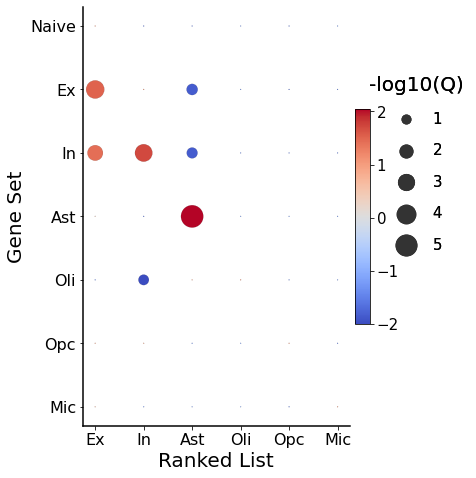

In [186]:
## Generate Figure for Adult Onset Dataset
plt.rcParams['font.family'] = 'Arial'
padj_df = padj_dfs['Adult']
es_df = es_dfs['Adult']
plot_data = padj_df.copy()

plot_data = plot_data.reset_index().melt(id_vars='index')
plot_data.columns = ['Gene Set', 'Ranked List', '-log10(Q)']
plot_data['NES'] = es_df.reset_index().melt(id_vars='index')['value']

# Filter out non-significant values (where -log10(p-value) < 1)
plot_data['-log10(Q)'] = plot_data['-log10(Q)'].apply(lambda x: x if x >= 1 else 0.1)

# Create the dot plot
fig, ax = plt.subplots(figsize=(7, 9))
dot_plot = sns.scatterplot(
    data=plot_data,
    x='Ranked List',
    y='Gene Set',
    size='-log10(Q)',
    hue='NES',
    palette='coolwarm',  # Red to blue color palette
    sizes=(1, 500),  # Adjust size range for the dots
    edgecolor='black',
    ax=ax
)

# Customize plot appearance
ax.set_xlabel('Ranked List', fontsize=20)
ax.set_ylabel('Gene Set', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Remove the default legend
handles, labels = dot_plot.get_legend_handles_labels()
dot_plot.legend([], [], frameon=False)

# Create a custom size legend
size_legend = ax.legend(
    handles[8:],  # Adjust according to the number of sizes
    labels[8:],  # Adjust according to the number of sizes
    title='-log10(Q)',
    bbox_to_anchor=(1.05, 0.85),
    loc='upper left',
    borderaxespad=0.,
    frameon=False, 
    labelspacing=1.1,
    title_fontsize=20,
    fontsize=15
)

# Add the size legend back
ax.add_artist(size_legend)

# Create a custom hue legend (for NES)
norm = plt.Normalize(vmin=-2, vmax=plot_data['NES'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.02)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_aspect(15)
cbar.ax.set_position([1.05, 0.75, 0.03, 0.4])

# save
fig.savefig('../Figures/Adult_Onset_Enrichment_DotPlot.png', format='png', bbox_inches='tight')
fig.savefig('../Figures/Adult_Onset_Enrichment_DotPlot.eps', format='eps', bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

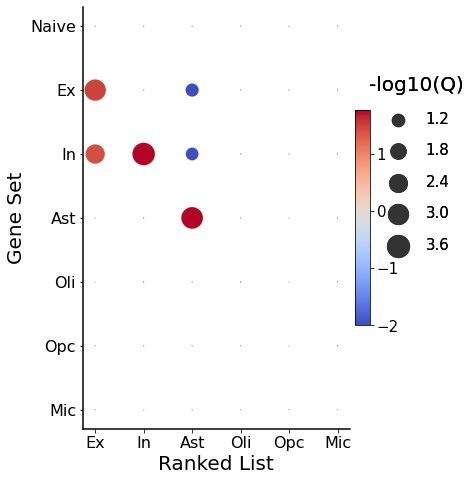

In [188]:
## Generate Figure for Adult Onset Dataset
plt.rcParams['font.family'] = 'Arial'
padj_df = padj_dfs['Juv']
es_df = es_dfs['Juv']
plot_data = padj_df.copy()

plot_data = plot_data.reset_index().melt(id_vars='index')
plot_data.columns = ['Gene Set', 'Ranked List', '-log10(Q)']
plot_data['NES'] = es_df.reset_index().melt(id_vars='index')['value']

# Filter out non-significant values (where -log10(p-value) < 1)
plot_data['-log10(Q)'] = plot_data['-log10(Q)'].apply(lambda x: x if x >= 1 else 0.1)

# Create the dot plot
fig, ax = plt.subplots(figsize=(7, 9))
dot_plot = sns.scatterplot(
    data=plot_data,
    x='Ranked List',
    y='Gene Set',
    size='-log10(Q)',
    hue='NES',
    palette='coolwarm',  # Red to blue color palette
    sizes=(1, 500),  # Adjust size range for the dots
    edgecolor='black',
    ax=ax
)

# Customize plot appearance
ax.set_xlabel('Ranked List', fontsize=20)
ax.set_ylabel('Gene Set', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Remove the default legend
handles, labels = dot_plot.get_legend_handles_labels()
dot_plot.legend([], [], frameon=False)

# Create a custom size legend
size_legend = ax.legend(
    handles[8:],  # Adjust according to the number of sizes
    labels[8:],  # Adjust according to the number of sizes
    title='-log10(Q)',
    bbox_to_anchor=(1.05, 0.85),
    loc='upper left',
    borderaxespad=0.,
    frameon=False, 
    labelspacing=1.1,
    title_fontsize=20,
    fontsize=15
)

# Add the size legend back
ax.add_artist(size_legend)

# Create a custom hue legend (for NES)
norm = plt.Normalize(vmin=-2, vmax=plot_data['NES'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.02)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_aspect(15)
cbar.ax.set_position([1.05, 0.75, 0.03, 0.4])

# save
fig.savefig('../Figures/Juv_Onset_Enrichment_DotPlot.png', format='png', bbox_inches='tight')
fig.savefig('../Figures/Juv_Onset_Enrichment_DotPlot.eps', format='eps', bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

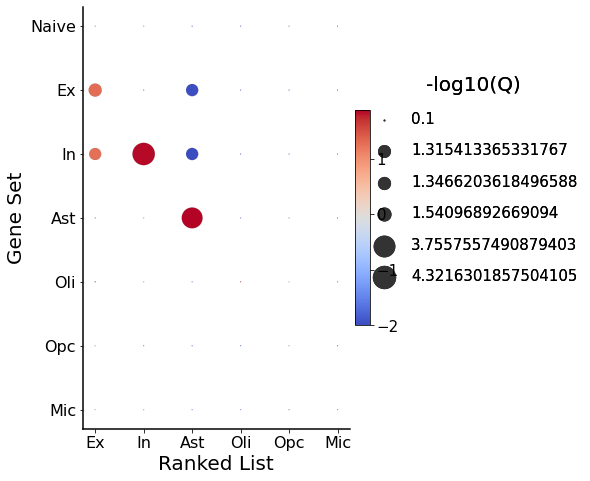

In [189]:
## Generate Figure for Adult Onset Dataset
plt.rcParams['font.family'] = 'Arial'
padj_df = padj_dfs['Ctrl']
es_df = es_dfs['Ctrl']
plot_data = padj_df.copy()

plot_data = plot_data.reset_index().melt(id_vars='index')
plot_data.columns = ['Gene Set', 'Ranked List', '-log10(Q)']
plot_data['NES'] = es_df.reset_index().melt(id_vars='index')['value']

# Filter out non-significant values (where -log10(p-value) < 1)
plot_data['-log10(Q)'] = plot_data['-log10(Q)'].apply(lambda x: x if x >= 1 else 0.1)

# Create the dot plot
fig, ax = plt.subplots(figsize=(7, 9))
dot_plot = sns.scatterplot(
    data=plot_data,
    x='Ranked List',
    y='Gene Set',
    size='-log10(Q)',
    hue='NES',
    palette='coolwarm',  # Red to blue color palette
    sizes=(1, 500),  # Adjust size range for the dots
    edgecolor='black',
    ax=ax
)

# Customize plot appearance
ax.set_xlabel('Ranked List', fontsize=20)
ax.set_ylabel('Gene Set', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

# Remove the default legend
handles, labels = dot_plot.get_legend_handles_labels()
dot_plot.legend([], [], frameon=False)

# Create a custom size legend
size_legend = ax.legend(
    handles[8:],  # Adjust according to the number of sizes
    labels[8:],  # Adjust according to the number of sizes
    title='-log10(Q)',
    bbox_to_anchor=(1.05, 0.85),
    loc='upper left',
    borderaxespad=0.,
    frameon=False, 
    labelspacing=1.1,
    title_fontsize=20,
    fontsize=15
)

# Add the size legend back
ax.add_artist(size_legend)

# Create a custom hue legend (for NES)
norm = plt.Normalize(vmin=-2, vmax=plot_data['NES'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.02)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_aspect(15)
cbar.ax.set_position([1.05, 0.75, 0.03, 0.4])

# save
fig.savefig('../Figures/Adult_Onset_Enrichment_DotPlot.png', format='png', bbox_inches='tight')
fig.savefig('../Figures/Adult_Onset_Enrichment_DotPlot.eps', format='eps', bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

## Assess node/edge similarity for additional validation

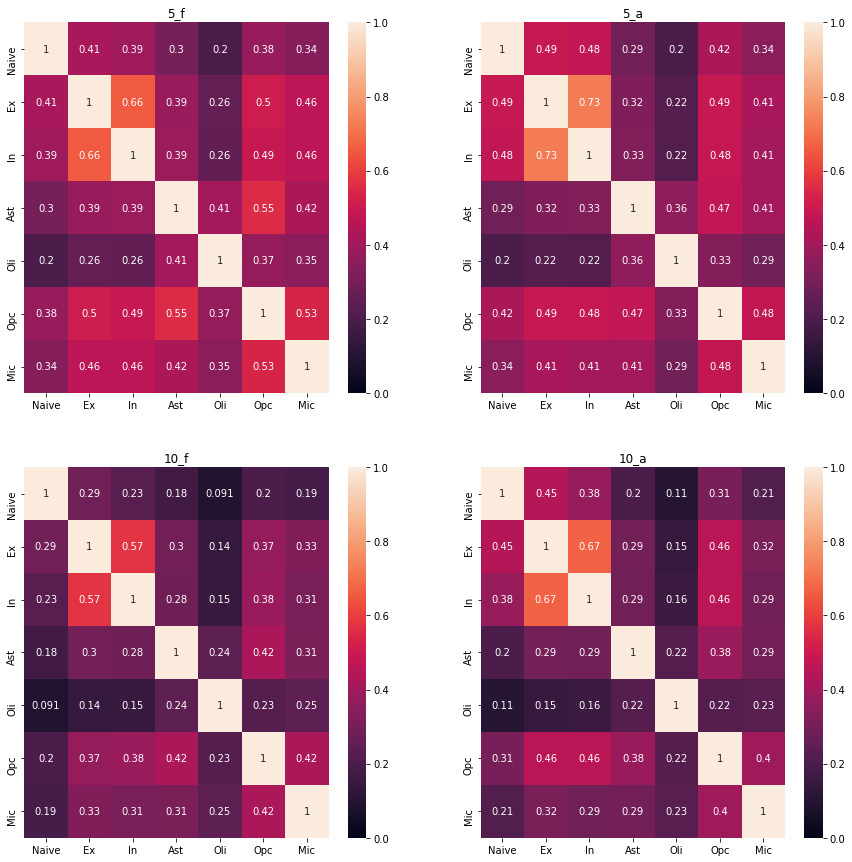

In [190]:
# Edge similarity
n=2
m=2
c=0
jaccard_edge={}
jaccard_edge['5_f'] = pairwise_jaccard_index_from_networks(final_networks_5, mode='forest')
jaccard_edge['5_a'] = pairwise_jaccard_index_from_networks(final_networks_5, mode='augmented_forest')
jaccard_edge['10_f'] = pairwise_jaccard_index_from_networks(final_networks_10, mode='forest')
jaccard_edge['10_a'] = pairwise_jaccard_index_from_networks(final_networks_10, mode='augmented_forest')
fix, axes = plt.subplots(2,2, figsize=(15,15))
for i in range(n):
    for j in range(m):
        key = list(jaccard_edge.keys())[c]
        df = jaccard_edge[key]
        sns.heatmap(df, annot=True, ax=axes[i][j], vmin=0, vmax=1)
        c=c+1
        axes[i][j].set_title(key)

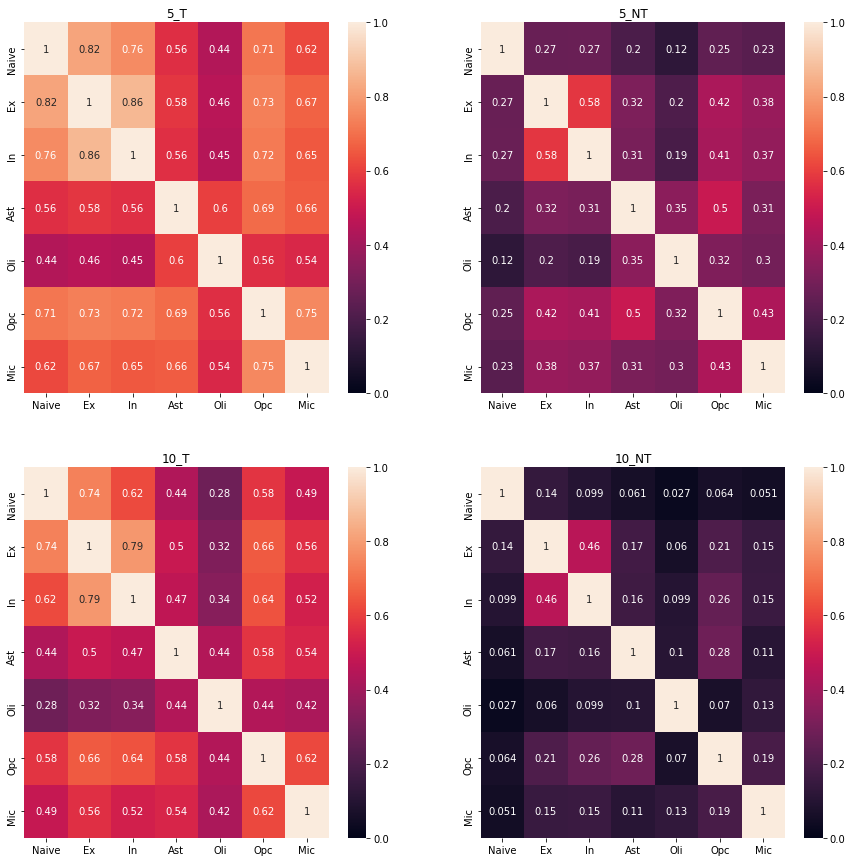

In [191]:
# node similarity
n=2
m=2
c=0
jaccard_node={}
jaccard_node['5_T'] = pairwise_jaccard_index_from_network_nodes(final_networks_5, mode='Terminal')
jaccard_node['5_NT'] = pairwise_jaccard_index_from_network_nodes(final_networks_5, mode='Non-terminal')
jaccard_node['10_T'] = pairwise_jaccard_index_from_network_nodes(final_networks_10, mode='Terminal')
jaccard_node['10_NT'] = pairwise_jaccard_index_from_network_nodes(final_networks_10, mode='Non-terminal')
fix, axes = plt.subplots(2,2, figsize=(15,15))
for i in range(n):
    for j in range(m):
        key = list(jaccard_node.keys())[c]
        df = jaccard_node[key]
        sns.heatmap(df, annot=True, ax=axes[i][j], vmin=0, vmax=1)
        c=c+1
        axes[i][j].set_title(key)

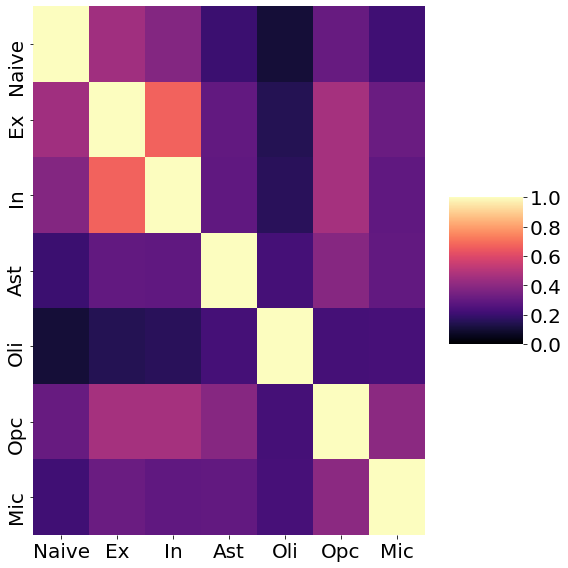

In [213]:
# select one panel and export
jaccard_edge['10_a'] = pairwise_jaccard_index_from_networks(final_networks_10, mode='augmented_forest')
fig, ax = plt.subplots(1,1, figsize=(8,8))
df = jaccard_edge['10_a']
heatmap = sns.heatmap(df, annot=False, ax=ax, vmin=0, vmax=1, 
                      cmap = 'magma',
                      cbar_kws={'ticks': [0, 0.2, 0.4, 0.6, 0.8, 1.0]})

# Customize plot appearance

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.yaxis.label.set_rotation(90)
# Customize colorbar appearance
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_aspect(2)
# Adjust layout
plt.tight_layout()

# Save the plot as PNG and EPS files
fig.savefig('../Figures/Edge_Similarity_K10_Augmented.png', format='png', bbox_inches='tight')
fig.savefig('../Figures/Edge_Similarity_K10_Augmented.eps', format='eps', bbox_inches='tight')

# Show the plot
plt.show()